### JDCWC

Simulation ended after 2000 rounds. Alive nodes: 10


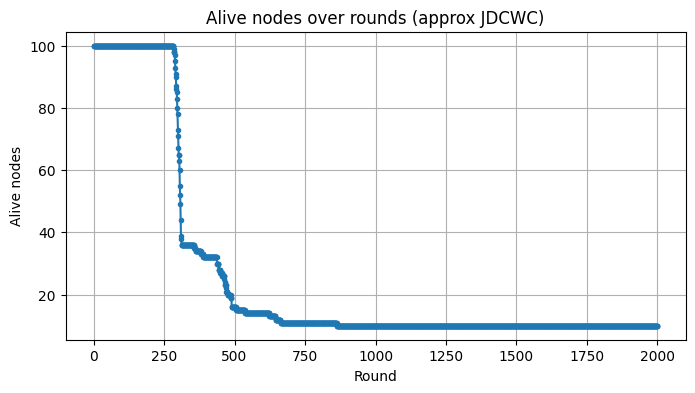

In [1]:
# jdcwc_sim.py
# پیاده‌سازی تقریبی JDCWC برای به‌دست آوردن "دور آخرین نود مرده"
# قابل اجرا با Python 3.8+. فقط نیاز به numpy و scikit-learn و matplotlib (اختیاری) دارد.
# pip install numpy scikit-learn matplotlib

import numpy as np
from sklearn.cluster import KMeans
import math
import random
import matplotlib.pyplot as plt

# -----------------------
# تنظیمات (از جدول مقاله گرفته شده؛ قابل تغییر)
AREA_SIZE = 100          # 100 x 100 m^2
NUM_NODES = 100          # از مقاله
INIT_ENERGY = 0.5        # Joules
CH_PROB = 0.1            # احتمال انتخاب CH
MAX_ROUNDS = 2000        # از مقاله
DATA_PACKET_SIZE = 4000  # Bytes (استفادهٔ نمادین)
E_ELEC = 50e-9           # 50 * 1e-9 J/bit (به‌صورت نمادین)
EDA = 5e-9               # Data aggregation energy
Efs = 10e-12             # Efs
Emp = 0.0013e-12         # Emp
THRESHOLD_ENERGY = 0.1 * INIT_ENERGY  # آستانهٔ شارژ (تقریبی: 10% از انرژی اولیه)
MOBILE_VAN_SPEED = 10.0  # m per round (نمادین سرعت حرکت Mobile VAN)
CHARGE_AMOUNT = 0.3      # مقدار Joules که Mobile VAN برمی‌گرداند (نمادین)

# تبدیل بایت به بیت
def bytes_to_bits(b): return b * 8

# فرمول انرژی ارسال (مدل رادیویی ساده)
def energy_tx(k_bits, distance):
    k = k_bits
    # اگر distance < do استفاده از Efs، وگرنه Emp (طبق مقاله do = sqrt(Efs/Emp))
    do = math.sqrt(Efs / Emp) if Emp>0 else 87.0
    if distance <= do:
        amp = Efs
    else:
        amp = Emp
    return (E_ELEC * k) + (amp * k * (distance**2))

def energy_rx(k_bits):
    return E_ELEC * k_bits

# ایجاد گره‌ها
np.random.seed(42)
nodes_pos = np.random.uniform(0, AREA_SIZE, size=(NUM_NODES, 2))
nodes_energy = np.full(NUM_NODES, INIT_ENERGY)
alive = np.ones(NUM_NODES, dtype=bool)

# Base station در مرکز (طبق جدول: 50,50)
BS_POS = np.array([AREA_SIZE/2, AREA_SIZE/2])

# تعداد CH تقریبی
k_clusters = max(1, round(CH_PROB * NUM_NODES))

# ثبت نتایج
alive_history = []
last_dead_round = None

# انتخاب خوشه‌ها با kmeans هر چند دور (می‌توان هر 10 دور به‌روزرسانی کرد)
def elect_cluster_heads(positions, k):
    # استفاده از KMeans برای تعیین مراکز؛ سپس نزدیک‌ترین گره به هر مرکز شود CH
    k = min(k, len(positions))
    if k <= 0:
        return []
    kmeans = KMeans(n_clusters=k, random_state=0).fit(positions)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    ch_indices = []
    for ci in range(k):
        members = np.where(labels == ci)[0]
        if len(members) == 0:
            continue
        # نزدیک‌ترین عضو به مرکز به عنوان CH
        dists = np.linalg.norm(positions[members] - centers[ci], axis=1)
        idx = members[np.argmin(dists)]
        ch_indices.append(idx)
    return ch_indices

# شبیه‌سازی دورها
for r in range(1, MAX_ROUNDS+1):
    # اگر هیچ گرهٔ زنده‌ای نمانده، زود خروج
    if not alive.any():
        last_dead_round = r-1
        print("All nodes dead at round", last_dead_round)
        break

    # به‌روز کردن خوشه‌ها (در این پیاده‌سازی هر دور)
    alive_positions = nodes_pos[alive]
    alive_indices = np.where(alive)[0]
    if len(alive_indices) == 0:
        last_dead_round = r-1
        break
    ch_candidates = elect_cluster_heads(alive_positions, k_clusters)
    # map local indices back to global
    CHs = [alive_indices[i] for i in ch_candidates]

    # هر گره (غیر-CH) داده می‌فرستد به CH نزدیک خود
    # ابتدا برای هر گره نزدیک‌ترین CH را پیدا کن
    for ni in alive_indices:
        if ni in CHs:
            continue
        # پیدا کردن نزدیک‌ترین CH
        ch_dists = [(ch, np.linalg.norm(nodes_pos[ni]-nodes_pos[ch])) for ch in CHs]
        if not ch_dists:
            continue
        ch, dist = min(ch_dists, key=lambda x: x[1])
        # ارسال از گره به CH
        kbits = bytes_to_bits(DATA_PACKET_SIZE)
        e_tx = energy_tx(kbits, dist)
        e_rx = energy_rx(kbits)
        # به‌روز کردن انرژی فرستنده و دریافت‌کننده (CH)
        nodes_energy[ni] -= e_tx
        nodes_energy[ch] -= e_rx  # شارژ مصرف شده برای دریافت (چون CH انرژی مصرف می‌کند)
        if nodes_energy[ni] <= 0:
            alive[ni] = False
            nodes_energy[ni] = 0.0

    # سپس هر CH دادهٔ جمع‌شده را به BS می‌فرستد (فاصله CH->BS)
    for ch in CHs:
        if not alive[ch]:
            continue
        dist_bs = np.linalg.norm(nodes_pos[ch] - BS_POS)
        kbits = bytes_to_bits(DATA_PACKET_SIZE)  # فرض: بستهٔ تجمعی هم‌اندازه (نمادین)
        e_tx = energy_tx(kbits, dist_bs)
        nodes_energy[ch] -= e_tx
        if nodes_energy[ch] <= 0:
            alive[ch] = False
            nodes_energy[ch] = 0.0

    # هر CH که زیر آستانه است درخواست شارژ می‌زند
    requests = [ch for ch in CHs if alive[ch] and nodes_energy[ch] < THRESHOLD_ENERGY]

    # Mobile VAN سرویس‌رسانی: مسیر ساده بر اساس ترتیب نزدیک‌ترین (greedy TSP approx)
    if requests:
        van_pos = BS_POS.copy()
        pending = set(requests)
        while pending:
            # انتخاب نزدیک‌ترین CH
            nearest = min(pending, key=lambda c: np.linalg.norm(nodes_pos[c]-van_pos))
            dist_to = np.linalg.norm(nodes_pos[nearest]-van_pos)
            # حرکت VAN (ما زمان حرکت را نادیده می‌گیریم اما انرژی VAN تاثیری ندارد)
            van_pos = nodes_pos[nearest].copy()
            # شارژ کردن: مقدار مشخص به CH بازمی‌گردد (تا INIT_ENERGY حداکثر)
            nodes_energy[nearest] = min(INIT_ENERGY, nodes_energy[nearest] + CHARGE_AMOUNT)
            pending.remove(nearest)
        # VAN به BS برمی‌گردد (بدون اثر بیشتر)
        van_pos = BS_POS.copy()

    # هر گره‌ای که انرژی‌اش <= 0 علامت‌گذاری شد بالاتر؛ همچنین ممکن است بعضی‌ها تازه بمیرند
    newly_dead = np.where((nodes_energy <= 0) & alive)[0]
    for nd in newly_dead:
        alive[nd] = False

    num_alive = alive.sum()
    alive_history.append(num_alive)

    # اگر این دور باعث شد هیچ گره زنده نماند، ثبت کن
    if num_alive == 0:
        last_dead_round = r
        print("All nodes dead at round", last_dead_round)
        break

# اگر حلقه تمام شد و هنوز گره‌هایی زنده‌اند، last_dead_round = None
if last_dead_round is None:
    print("Simulation ended after", MAX_ROUNDS, "rounds. Alive nodes:", alive.sum())
else:
    print("Last dead round:", last_dead_round)

# نمودار تعداد نودهای زنده بر حسب دور
plt.figure(figsize=(8,4))
plt.plot(range(1, 1+len(alive_history)), alive_history, '-o', markersize=3)
plt.xlabel('Round')
plt.ylabel('Alive nodes')
plt.title('Alive nodes over rounds (approx JDCWC)')
plt.grid(True)
plt.show()


### CHBCO

All nodes dead at round 267
Last dead round: 267


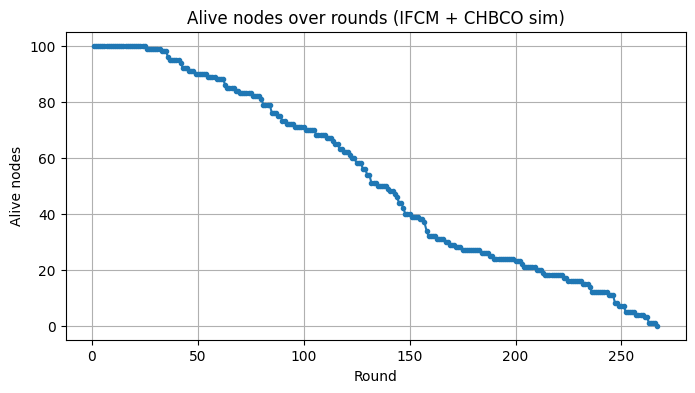

In [1]:
# chbco_sim.py
# Practical implementation of IFCM + CHBCO + Fault Tolerance (best-effort faithful to the paper)
# Uses parameters from Table 2 of the paper (see filecite).
# Run: python chbco_sim.py

import numpy as np
import math
import random
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.spatial.distance import cdist

# ---------------------------
# Parameters (from Table 2 in paper). See PDF for source. :contentReference[oaicite:3]{index=3}
AREA_SIZE = 100.0
BS_POS = np.array([AREA_SIZE/2, AREA_SIZE/2])
NUM_NODES = 100
INIT_ENERGY = 0.5
CH_PROB = 0.1
MAX_ROUNDS = 2000

# Radio model params (Table 2). :contentReference[oaicite:4]{index=4}
E_ELEC = 50e-9
EDA = 5e-9
Efs = 10e-12
Emp = 0.0013e-12

DATA_PKT_BYTES = 4000
def bytes_to_bits(b): return b*8

# Fault tolerance threshold and CH re-charge threshold
THRESHOLD_ENERGY = 0.1 * INIT_ENERGY
CHARGE_AMOUNT = 0.3  # when we "recover" a CH (practical choice)

# CHBCO optimizer parameters (population-based)
POP_SIZE = 20       # population (number of honey badgers)
ITER_CHBCO = 30     # optimizer iterations per routing call
W1, W2, W3 = 0.4, 0.4, 0.2  # weights for objective Eq.(33) (sum to 1) :contentReference[oaicite:5]{index=5}

# ---------------------------
np.random.seed(123)

# create nodes randomly
nodes_pos = np.random.uniform(0, AREA_SIZE, (NUM_NODES, 2))
nodes_energy = np.full(NUM_NODES, INIT_ENERGY)
alive = np.ones(NUM_NODES, dtype=bool)

# helper energy functions
def d0():
    return math.sqrt(Efs/Emp) if Emp>0 else 87.0

def energy_tx(kbits, dist):
    amp = Efs if dist <= d0() else Emp
    return (E_ELEC * kbits) + (amp * kbits * (dist**2))

def energy_rx(kbits):
    return E_ELEC * kbits

# ---------------------------
# IFCM clustering (improved FCM using Chebyshev distance and energy-awareness)
def ifcm_clustering(positions, energies, n_clusters):
    # Implementation: FCM with Chebyshev distance and energy-weighted initialization
    # positions: (m,2), energies: (m,)
    m = 2.0  # fuzziness
    max_iter = 100
    eps = 1e-4
    n = positions.shape[0]
    n_clusters = min(n_clusters, n)
    # initialize centers: pick nodes with higher energy as seeds
    idx_sorted = np.argsort(-energies)
    centers = positions[idx_sorted[:n_clusters]].astype(float)

    def chebyshev_dist(a, b):
        # a: (N,d), b: (M,d) -> (N,M)
        return cdist(a, b, metric='chebyshev')

    U = np.zeros((n, n_clusters))  # membership matrix
    for it in range(max_iter):
        D = chebyshev_dist(positions, centers) + 1e-12
        # incorporate energy by scaling distances: nodes with higher energy "closer" to centers
        energy_factor = (energies.max() - energies) / (energies.max() + 1e-12)  # higher energy -> smaller factor
        D = D * (1.0 + energy_factor[:, None]*0.3)  # modest influence
        # update U
        for j in range(n_clusters):
            denom = (D[:, j][:,None] / D)**(2.0/(m-1))
            U[:, j] = 1.0 / (denom.sum(axis=1) + 1e-12)
        # update centers
        centers_new = np.zeros_like(centers)
        for j in range(n_clusters):
            um = U[:, j]**m
            centers_new[j] = (um[:,None]*positions).sum(axis=0) / (um.sum()+1e-12)
        if np.linalg.norm(centers_new - centers) < eps:
            centers = centers_new
            break
        centers = centers_new
    # assign crisp clusters
    labels = np.argmax(U, axis=1)
    clusters = [np.where(labels==j)[0] for j in range(n_clusters)]
    return centers, clusters, labels

# ---------------------------
# CH selection per cluster: node nearest to center and with high energy
def choose_CHs(clusters, centers, positions, energies):
    CHs = []
    for j, members in enumerate(clusters):
        if len(members)==0: continue
        dists = np.max(np.abs(positions[members] - centers[j]), axis=1)  # Chebyshev dist
        # pick candidate with smallest dist; if several, pick one with highest energy
        best_idx = members[np.argmin(dists)]
        # but ensure alive and positive energy
        candidates = [idx for idx in members if alive[idx]]
        if not candidates:
            continue
        # choose by combined score: small dist, high energy
        scores = []
        for c in candidates:
            score = (np.max(np.abs(positions[c] - centers[j]))) - 0.5*(energies[c]/INIT_ENERGY)
            scores.append(score)
        pick = candidates[np.argmin(scores)]
        CHs.append(pick)
    return CHs

# ---------------------------
# Utility: compute link quality (simulate). We model linkquality in [0,1] decreasing with distance and low energy
def estimate_link_quality(a_idx, b_idx=None, pos=None, energy=None):
    # if b_idx is None and pos provided -> evaluate a->BS
    if b_idx is None:
        dist = np.linalg.norm(pos - BS_POS)
    else:
        dist = np.linalg.norm(nodes_pos[a_idx] - nodes_pos[b_idx])
    # map distance to quality (sigmoid-like)
    maxd = math.sqrt(2*(AREA_SIZE**2))
    q_dist = 1.0 - (dist / maxd)
    q_energy = (nodes_energy[a_idx] / INIT_ENERGY)
    return float(np.clip(0.2*q_dist + 0.8*q_energy, 0.0, 1.0))

# ---------------------------
# CHBCO optimizer (population-based). Each agent = binary vector length = num_CHs indicating allowed intermediate CHs.
# For a source CH, we derive a path greedily: from source CH, iteratively jump to nearest allowed CH that reduces distance to BS,
# finally direct to BS. Path cost computed via ob (Eq.33).
def decode_agent_to_path(agent_bin, CH_list, src_idx):
    # agent_bin: array of 0/1 for each CH in CH_list
    allowed = [CH_list[i] for i,v in enumerate(agent_bin) if v==1 and CH_list[i]!=src_idx]
    path = [src_idx]
    cur = src_idx
    visited = set([cur])
    # greedy hops up to len(allowed)+3
    for _ in range(len(allowed)+3):
        # candidates: allowed CHs not visited
        cands = [c for c in allowed if c not in visited]
        if not cands:
            break
        # pick candidate that minimizes (distance to BS after hop + small term)
        best = None; best_score=1e18
        for c in cands:
            d1 = np.linalg.norm(nodes_pos[cur] - nodes_pos[c])
            d2 = np.linalg.norm(nodes_pos[c] - BS_POS)
            score = d1 + d2
            if score < best_score:
                best_score=score; best=c
        if best is None:
            break
        path.append(best); visited.add(best); cur=best
        # if this node is very close to BS, finish
        if np.linalg.norm(nodes_pos[cur] - BS_POS) < 15.0:
            break
    # finally add BS as terminal (we won't add BS index in path array; interpret final hop to BS)
    return path

def path_distance(path):
    dist = 0.0
    for i in range(len(path)-1):
        dist += np.linalg.norm(nodes_pos[path[i]] - nodes_pos[path[i+1]])
    # add last hop to BS
    dist += np.linalg.norm(nodes_pos[path[-1]] - BS_POS)
    return dist

def compute_objective_for_path(path):
    # Compose normalized terms for Eq.(33): ob = w1*(1-energy) + w2*dist + w3*(1-linkquality)
    # energy term: average residual energy along path nodes normalized to [0,1]
    energies = nodes_energy[path]
    avg_energy = float(np.mean(energies)/INIT_ENERGY) if len(energies)>0 else 0.0
    energy_term = 1.0 - avg_energy  # want routes with higher energy -> smaller ob
    # distance normalized
    dist = path_distance(path)
    max_possible = math.sqrt(2*(AREA_SIZE**2))* (len(path)+1)
    dist_term = dist / (max_possible + 1e-12)
    # link quality: average estimated quality for hops
    lqs = [estimate_link_quality(p, None, pos=nodes_pos[p]) for p in path]
    avg_lq = float(np.mean(lqs)) if lqs else 0.0
    lq_term = 1.0 - avg_lq
    ob = W1*energy_term + W2*dist_term + W3*lq_term
    return ob, dist, avg_lq

# Chebyshev map randomizer
def chebyshev_map(x, k=2):
    # x in (0,1) mapped to (-1,1) for cos-arccos
    y = 2*x - 1.0
    # ensure in [-1,1]
    y = np.clip(y, -1.0, 1.0)
    val = math.cos(k * math.acos(y))
    # map back to (0,1)
    return (val + 1.0)/2.0

def chbco_optimize_for_src(CH_list, src_idx):
    nCH = len(CH_list)
    # population: binary vectors length nCH (we ignore the bit corresponding to src)
    pop = np.random.randint(0,2,(POP_SIZE, nCH))
    # ensure src's own index bit is 0 (it is source)
    src_pos_in_CHlist = CH_list.index(src_idx)
    pop[:, src_pos_in_CHlist] = 0
    # keep best
    best_agent = None; best_val = 1e18; best_path=None
    # initial chebyshev seed
    r = np.random.rand()
    for it in range(ITER_CHBCO):
        for i in range(POP_SIZE):
            agent = pop[i]
            # decode to path and score
            path = decode_agent_to_path(agent, CH_list, src_idx)
            if len(path)==0: 
                val=1e9
            else:
                val,_,_ = compute_objective_for_path(path)
            if val < best_val:
                best_val = val; best_agent = agent.copy(); best_path = path.copy()
        # update population: hybrid HBA+COA simplified
        # compute population fitnesses
        fitness = np.zeros(POP_SIZE)
        for i in range(POP_SIZE):
            p = pop[i]
            path = decode_agent_to_path(p, CH_list, src_idx)
            fitness[i] = compute_objective_for_path(path)[0] if len(path)>0 else 1e6
        # rank
        ranks = np.argsort(fitness)
        leader = pop[ranks[0]].copy()
        # update agents
        for i in range(POP_SIZE):
            cur = pop[i].copy().astype(float)
            # HBA-inspired digging/honey move: move towards leader and a random agent
            rand_agent = pop[np.random.randint(0,POP_SIZE)].astype(float)
            alpha = 0.4 * np.random.rand()
            beta = 0.4 * np.random.rand()
            new = cur + alpha*(leader - cur) + beta*(rand_agent - cur)
            # COA-inspired leader attraction term
            A = np.random.rand()
            new = new + A * (leader - new) * (np.random.rand())
            # chebyshev perturbation
            r = chebyshev_map(r, k=2+ (it%3))
            # binarize new via sigmoid
            sig = 1.0/(1.0 + np.exp(-10*(new - 0.5)))
            new_bin = (sig > r).astype(int)
            # ensure src bit zero
            new_bin[src_pos_in_CHlist] = 0
            pop[i] = new_bin
    return best_agent, best_val, best_path

# ---------------------------
# Fault tolerance (Algorithm 2): detect CH failure (no ACK) -> choose new CH based on cost Eq.(34)
# We'll implement a function that given a failed CH index, picks replacement among its cluster members
CH_history_count = {}  # how many times a node has been CH previously (NBPR)
def recover_CH(failed_ch, cluster_members):
    # get candidate members (alive)
    candidates = [c for c in cluster_members if alive[c] and c!=failed_ch]
    if not candidates:
        return None
    # compute cost per Eq.(34). We'll implement EC terms as ratio of available transmit energy to residual.
    costs = []
    NCCR = len(cluster_members)
    for a in candidates:
        # EC_ai_ak approximate: available energy for si->ai normalized
        NE_si_ai = nodes_energy[a]  # available energy at candidate
        RE_si = nodes_energy[a] + 1e-12
        EC_si_ai = NE_si_ai / RE_si
        # EC ak->sink:
        dist_to_sink = np.linalg.norm(nodes_pos[a] - BS_POS)
        NE_ai_sink = nodes_energy[a]  # approximate available energy
        RE_ai = nodes_energy[a] + 1e-12
        EC_ak_sink = NE_ai_sink / RE_ai
        NBPR = CH_history_count.get(a, 0) + 1e-12
        dist = dist_to_sink
        # Cost per paper: Cost(ai,ak) = 1 / (EC_ai_ak * EC_ak*Sink * NCCR(ak) * NBPR(ak) * dist)
        denom = (EC_si_ai * EC_ak_sink * max(1,NCCR) * NBPR * (dist+1e-6))
        cost = 1.0 / (denom + 1e-12)
        costs.append(cost)
    # choose min cost
    pick = candidates[np.argmin(costs)]
    CH_history_count[pick] = CH_history_count.get(pick,0)+1
    # "top-up" energy a bit to simulate takeover
    nodes_energy[pick] = min(INIT_ENERGY, nodes_energy[pick] + CHARGE_AMOUNT/2.0)
    return pick

# ---------------------------
# Simulation main loop
alive_history = []
last_dead_round = None

# We'll update clusters every round (as in paper they may recompute)
for r in range(1, MAX_ROUNDS+1):
    if not alive.any():
        last_dead_round = r-1
        print("All nodes dead at round", last_dead_round)
        break

    # determine number of clusters k = round(p*N)
    k_clusters = max(1, round(CH_PROB * NUM_NODES))
    alive_idx = np.where(alive)[0]
    if len(alive_idx)==0:
        last_dead_round = r-1
        break
    # run IFCM on alive nodes
    centers, clusters, labels = ifcm_clustering(nodes_pos[alive_idx], nodes_energy[alive_idx], k_clusters)
    # map cluster member indices to global indices
    clusters_global = []
    for cl in clusters:
        clusters_global.append(alive_idx[cl].tolist())

    # choose CHs
    CHs = choose_CHs(clusters_global, centers, nodes_pos, nodes_energy)
    # remove duplicates
    CHs = list(dict.fromkeys(CHs))

    # Each non-CH alive node sends to its CH (nearest of CHs within same cluster)
    # Build mapping node->CH by nearest CH
    for ni in alive_idx:
        if ni in CHs:
            continue
        if not CHs: break
        dlist = [(ch, np.linalg.norm(nodes_pos[ni]-nodes_pos[ch])) for ch in CHs]
        ch, dist = min(dlist, key=lambda x: x[1])
        kbits = bytes_to_bits(DATA_PKT_BYTES)
        e_tx = energy_tx(kbits, dist)
        e_rx = energy_rx(kbits)
        nodes_energy[ni] -= e_tx
        nodes_energy[ch] -= e_rx  # CH receives
        if nodes_energy[ni] <= 0:
            nodes_energy[ni]=0.0; alive[ni]=False

    # CHs send to BS using optimized routing found by CHBCO. For each CH compute optimized path (multi-hop over CHs)
    if CHs:
        CH_list = CHs.copy()
        for ch in CH_list:
            if not alive[ch]: continue
            # run CHBCO optimizer for this CH to find best intermediate CHs set
            agent, val, path = chbco_optimize_for_src(CH_list, ch)
            # if optimizer failed, send direct
            if path is None or len(path)==0:
                # direct send
                dist_bs = np.linalg.norm(nodes_pos[ch] - BS_POS)
                kbits = bytes_to_bits(DATA_PKT_BYTES)
                e_tx = energy_tx(kbits, dist_bs)
                nodes_energy[ch] -= e_tx
                if nodes_energy[ch] <= 0:
                    nodes_energy[ch]=0.0; alive[ch]=False
                continue
            # consume energy along hops: each hop node transmits aggregated packet to next hop; intermediate nodes receive then re-transmit
            # For simplicity assume aggregated packet same size
            kbits = bytes_to_bits(DATA_PKT_BYTES)
            # iterate path hops
            for i in range(len(path)-1):
                a = path[i]; b = path[i+1]
                d = np.linalg.norm(nodes_pos[a]-nodes_pos[b])
                e_tx = energy_tx(kbits, d)
                e_rx = energy_rx(kbits)
                nodes_energy[a] -= e_tx
                nodes_energy[b] -= e_rx
                if nodes_energy[a] <= 0: nodes_energy[a]=0.0; alive[a]=False
                if nodes_energy[b] <= 0: nodes_energy[b]=0.0; alive[b]=False
            # last hop to BS
            last = path[-1]
            dbs = np.linalg.norm(nodes_pos[last] - BS_POS)
            e_tx = energy_tx(kbits, dbs)
            nodes_energy[last] -= e_tx
            if nodes_energy[last] <= 0: nodes_energy[last]=0.0; alive[last]=False

    # Fault detection: if a CH died during this round, run recovery for its cluster
    for j, ch in enumerate(CHs):
        if not alive[ch]:
            # find its cluster members
            members = clusters_global[j] if j < len(clusters_global) else []
            new_ch = recover_CH(ch, members)
            if new_ch is not None:
                # replace in CHs (for next round this will be used)
                # (we do not retroactively reroute this round)
                idx = CHs.index(ch)
                CHs[idx] = new_ch

    # update alive list
    newly_dead = np.where((nodes_energy <= 0) & alive)[0]
    for nd in newly_dead:
        alive[nd]=False
    alive_history.append(alive.sum())

    # record if now all dead
    if alive.sum() == 0:
        last_dead_round = r
        print("All nodes dead at round", last_dead_round)
        break

# end for rounds
if last_dead_round is None:
    print("Simulation ended after", MAX_ROUNDS, "rounds. Alive nodes:", alive.sum())
else:
    print("Last dead round:", last_dead_round)

# plot alive nodes over rounds
plt.figure(figsize=(8,4))
plt.plot(range(1,1+len(alive_history)), alive_history, '-o', markersize=3)
plt.xlabel('Round')
plt.ylabel('Alive nodes')
plt.title('Alive nodes over rounds (IFCM + CHBCO sim)')
plt.grid(True)
plt.show()
